In [1]:
# CHENGZHI DONG
# ID 112890166
# CSE 353 
# Assignment 6

In [2]:
# Import python libraries
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt

In [3]:
# Q-th order polynomial transform
def Poly_Transform(Q, x):
    # Calculate the Qth order polynomial transform by recursive
    # Base case if Q<0, z[n] = []
    if Q < 0:
        z = []
        for n in range(len(x)):
            z.append([])
        return z
    
    # z[n] = [x[n]^0, x[n]^1, x[n]^2, ..., x[n]^Q-1, x[n]^Q]
    else:
        z = Poly_Transform((Q-1), x)
        for n in range(len(x)):
            z[n].append(x[n]**Q)
        return z
    

In [4]:
# Linear Regression algorithm 
def LinearReg_Algorithm(x_data, y_data):
    # Closed form solution = (X^T * X)^-1 * X^T * Y
    x_transpose = np.transpose(x_data)
    xx = np.matmul(x_transpose, x_data)
    xx_inv = linalg.inv(xx)
    result = np.matmul(np.matmul(xx_inv, x_transpose), y_data)
    return result

In [5]:
# Calculate the square error
def Sqr_Err(w, z, y):
    error = 0
    for n in range(len(y)):
        error += (np.dot(w, z[n])- y[n])**2
    return error

In [6]:
# Regularization with lda
def Regularization(lda, z, y):
    # Closed form solution = (Z^T * Z + lambda*I)^-1 * Z^T * Y
    z_transpose = np.transpose(z)
    identity_matrix = np.identity(len(z_transpose))
    z_lda_inv = linalg.inv(np.matmul(z_transpose, z) + (lda*identity_matrix))
    result = np.matmul(np.matmul(z_lda_inv, z_transpose), y)
    return result

In [7]:
# Left-One-Out Cross Validation
def LOO(Q, lda, x, y):
    
    # Calculate the total error using each sample as validation
    total_err = 0
    for n in range(len(x)):
        z_loo = Poly_Transform(Q, x)
        y_temp = np.copy(y)
        z_val = z_loo.pop(n)
        y_val = y_temp[n]
        y_loo = np.delete(y_temp, n)
        w_loo = Regularization(lda, z_loo, y_loo)
        total_err += (np.dot(w_loo, z_val)- y_val)**2
        
    # Return the average error
    return total_err/len(x)

In [8]:
# V-Fold Cross Validation
def VFold(Q, lda, V, x, y):
    
    # Create list of V sub parts of z and y
    z_vfold = Poly_Transform(Q, x)
    z_parts = []
    y_parts = []
    for i in range(V):
        z_parts.append([])
        y_parts.append([])
    
    # Separate z and y into the V sub parts using module
    for n in range(len(y)):
        z_parts[n%V].append(z_vfold[n])
        y_parts[n%V].append(y[n])
        
    # Calculate the total error using validation with each sub part
    total_err = 0
    for k in range(V):
        z_temp = z_parts.copy()
        y_temp = y_parts.copy()
        
        # Set the k subpart as the validation
        z_val = z_temp.pop(k)
        y_val = y_temp.pop(k)
        
        # Combine the rest parts into a single list and use it as training data
        z_train = [j for i in z_temp for j in i]
        y_train = [j for i in y_temp for j in i]
        
        w_vfold = Regularization(lda, z_train, y_train)
        total_err += Sqr_Err(w_vfold, z_val, y_val)
        
    # Return the average error of the V parts
    return total_err/V

In [9]:
# Plot the data and estimated curve for visualization
def Visualization(Q, w, x_train, y_train, x_test, y_test, title):
    
    # Find min and max x for plot the estimated curve
    max_x = x_train[0]
    min_x = x_train[0]
    for n in x_train:
        if max_x < n:
            max_x = n
        if min_x > n:
            min_x = n
    for n in x_test:
        if max_x < n:
            max_x = n
        if min_x > n:
            min_x = n
    
    # Define the line space and curve g(x) = wz
    linespace = np.linspace(min_x-5, max_x+5, 100)
    linespace_poly = Poly_Transform(Q, linespace)
    g = []
    for p in linespace_poly:    
        g.append(np.dot(w, p))
    
    # Visualization
    plt.figure()
    plt.title(title)
    plt.scatter( x_train, y_train, color = "red", marker='o', label="Training Data")
    plt.scatter( x_test, y_test, color = "green", marker='d', label="Testing Data")
    plt.plot(linespace, g, 'blue')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()
    

In [10]:
# Load data
x_training = np.loadtxt("TrainingData_x.txt")
y_training = np.loadtxt("TrainingData_y.txt")
x_testing = np.loadtxt("TestingData_x.txt")
y_testing = np.loadtxt("TestingData_y.txt")

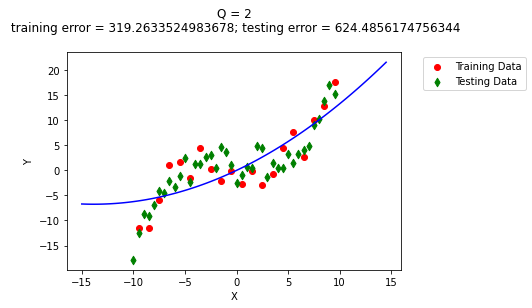

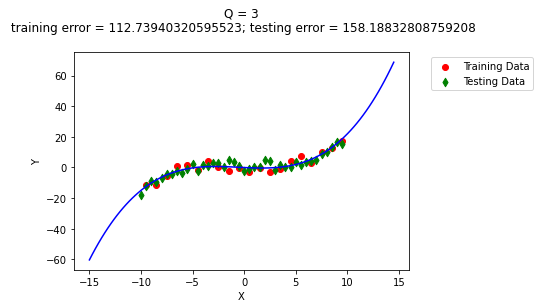

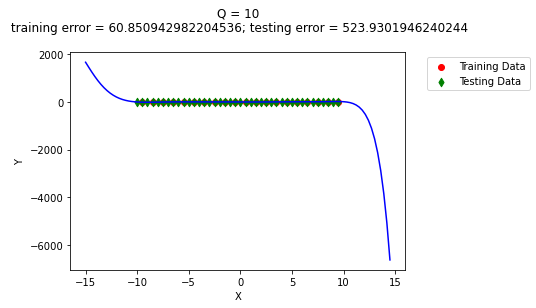

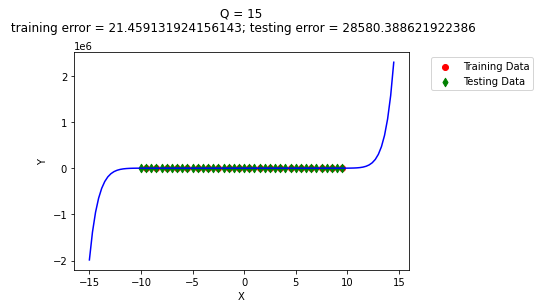

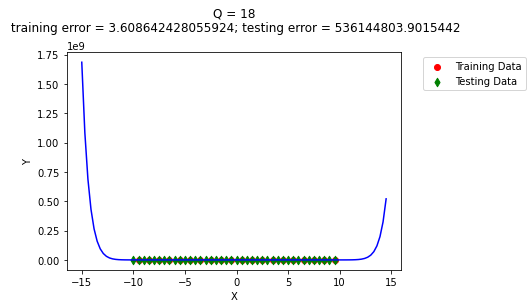

In [11]:
# Part 1. Nonlinear transform and overfitting/underfitting

# Define Q pool for polynomial transform
Q_pool = [2, 3, 10, 15, 18]

for Q in Q_pool:
    # Q-th order polynomial transform
    z_training = Poly_Transform(Q, x_training)

    # Linear regression on a transformed dataset
    w_poly = LinearReg_Algorithm(z_training, y_training)

    # Calculate trainging error
    train_error = Sqr_Err(w_poly, z_training, y_training)

    # Transform testing data and calculate the testing error
    z_testing = Poly_Transform(Q, x_testing)
    test_error = Sqr_Err(w_poly, z_testing, y_testing)

    # Plot the testing, training sample points, and estimated curve
    Visualization(Q, w_poly, x_training, y_training, x_testing, y_testing, "Q = "+str(Q)+"\n training error = "+str(train_error)+"; testing error = "+str(test_error)+"\n")

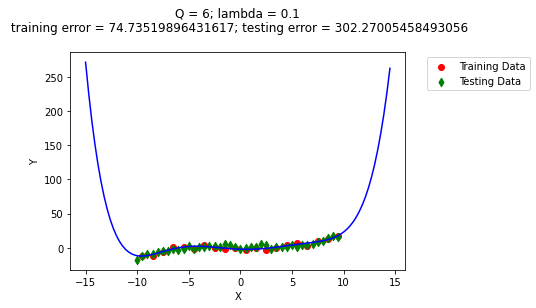

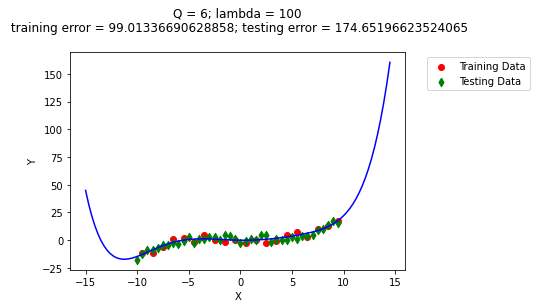

In [12]:
# Part 2. Regularization

# (1) Choose Q = 6 and lambda = 0.1
Q = 6
lda = 0.1

# Q-th order polynomial transform
z_training = Poly_Transform(Q, x_training)

# Regularization with lambda
w_regpoly = Regularization(lda, z_training, y_training)

# Calculate trainging error
train_error = Sqr_Err(w_regpoly, z_training, y_training)

# Transform testing data and calculate the testing error
z_testing = Poly_Transform(Q, x_testing)
test_error = Sqr_Err(w_regpoly, z_testing, y_testing)

# Plot the testing, training sample points, and estimated curve
Visualization(Q, w_regpoly, x_training, y_training, x_testing, y_testing, "Q = "+str(Q)+"; lambda = "+str(lda)+"\n training error = "+str(train_error)+"; testing error = "+str(test_error)+"\n")

# (2) Choose Q = 6 and lambda = 100
Q = 6
lda = 100

# Q-th order polynomial transform
z_training = Poly_Transform(Q, x_training)

# Regularization with lambda
w_regpoly = Regularization(lda, z_training, y_training)

# Calculate trainging error
train_error = Sqr_Err(w_regpoly, z_training, y_training)

# Transform testing data and calculate the testing error
z_testing = Poly_Transform(Q, x_testing)
test_error = Sqr_Err(w_regpoly, z_testing, y_testing)

# Plot the testing, training sample points, and estimated curve
Visualization(Q, w_regpoly, x_training, y_training, x_testing, y_testing, "Q = "+str(Q)+"; lambda = "+str(lda)+"\n training error = "+str(train_error)+"; testing error = "+str(test_error)+"\n")

In [13]:
# Part 3. Cross validation

# Leave-One-Out Cross Validation
# Set Q and lambda
Q = 6
print("\n Leave-One-Out Cross Validation with Q="+str(Q))
lda_pool = [0.01, 0.1, 1, 10, 100, 1000, 1000000]

# Best lambda 
lda_loo = 0
lda_loo_err = float("+inf")

# Loop through the lambda pool to choose the best one
for lda in lda_pool:
    current_err = LOO(Q, lda, x_training, y_training)
    print("Error with Lambda="+str(lda)+": "+str(current_err))
    if current_err < lda_loo_err:
        lda_loo = lda
        lda_loo_err = current_err
print("Best Lambda with Q="+str(Q)+": "+str(lda_loo))
 
# V-fold Cross Validation
# Set Q, V, and lambda
Q = 6
print("\n V-fold Cross Validation with Q="+str(Q))
V = 5
lda_pool = [0.01, 0.1, 1, 10, 100, 1000, 1000000]

# Best lambda 
lda_vfold = 0
lda_vfold_err = float("+inf")

# Loop through the lambda pool to choose the best one
for lda in lda_pool:
    current_err = VFold(Q, lda, V, x_training, y_training)
    print("Error with Lambda="+str(lda)+": "+str(current_err))
    if current_err < lda_vfold_err:
        lda_vfold = lda
        lda_vfold_err = current_err
print("Best Lambda with Q="+str(Q)+": "+str(lda_vfold))


# Cross Validation with other Q
# Leave-One-Out Cross Validation
print()
# Set Q and lambda
Q = 10
print("\n Leave-One-Out Cross Validation with Q="+str(Q))
lda_pool = [0.01, 0.1, 1, 10, 100, 1000, 1000000]

# Best lambda 
lda_loo = 0
lda_loo_err = float("+inf")

# Loop through the lambda pool to choose the best one
for lda in lda_pool:
    current_err = LOO(Q, lda, x_training, y_training)
    print("Error with Lambda="+str(lda)+": "+str(current_err))
    if current_err < lda_loo_err:
        lda_loo = lda
        lda_loo_err = current_err
print("Best Lambda with Q="+str(Q)+": "+str(lda_loo))
 
# V-fold Cross Validation
# Set Q, V, and lambda
Q = 10
print("\n V-fold Cross Validation with Q="+str(Q))
V = 5
lda_pool = [0.01, 0.1, 1, 10, 100, 1000, 1000000]

# Best lambda 
lda_vfold = 0
lda_vfold_err = float("+inf")

# Loop through the lambda pool to choose the best one
for lda in lda_pool:
    current_err = VFold(Q, lda, V, x_training, y_training)
    print("Error with Lambda="+str(lda)+": "+str(current_err))
    if current_err < lda_vfold_err:
        lda_vfold = lda
        lda_vfold_err = current_err
print("Best Lambda with Q="+str(Q)+": "+str(lda_vfold))


 Leave-One-Out Cross Validation with Q=6
Error with Lambda=0.01: 11.959704528258998
Error with Lambda=0.1: 11.978504970916356
Error with Lambda=1: 12.243661391796822
Error with Lambda=10: 14.265325821513409
Error with Lambda=100: 17.21702715106729
Error with Lambda=1000: 19.61844546691399
Error with Lambda=1000000: 19.876740966049404
Best Lambda with Q=6: 0.01

 V-fold Cross Validation with Q=6
Error with Lambda=0.01: 52.25299353151257
Error with Lambda=0.1: 52.374138354142154
Error with Lambda=1: 54.155771120480566
Error with Lambda=10: 66.90877749673209
Error with Lambda=100: 86.33252229435239
Error with Lambda=1000: 97.24873400820093
Error with Lambda=1000000: 74.79253037413402
Best Lambda with Q=6: 0.01


 Leave-One-Out Cross Validation with Q=10
Error with Lambda=0.01: 185.27490118782592
Error with Lambda=0.1: 180.22032368946256
Error with Lambda=1: 141.716982050026
Error with Lambda=10: 52.08619481619498
Error with Lambda=100: 17.34915194443675
Error with Lambda=1000: 13.9762451